In [0]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter


In [0]:
#La definición del dataset podéis encontrarla aquí https://archive.ics.uci.edu/ml/datasets/adult 

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None)
df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]
train_cols = df.columns[0:-1]
label = df.columns[-1]
X = df[train_cols]
y = df[label].apply(lambda x: 0 if x == " <=50K" else 1) # 0 o 1 dependiendo de si gana más de 50K



In [0]:
# Transformamos caracerísticas en números manteniendo el original
X_enc = pd.get_dummies(X, prefix_sep='.')
feature_names = list(X_enc.columns)


In [0]:
#Generamos datos de Entrenamiento y Test

seed = 1  
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.20, random_state=seed)

In [10]:
#¿Está balanceado?
Counter(y_train)

Counter({0: 19694, 1: 6354})

In [5]:

#Entrenamos el modelo
%%time

import xgboost as xgb
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

CPU times: user 1min 4s, sys: 90.1 ms, total: 1min 4s
Wall time: 1min 4s


In [7]:
#hacemos predicciones
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

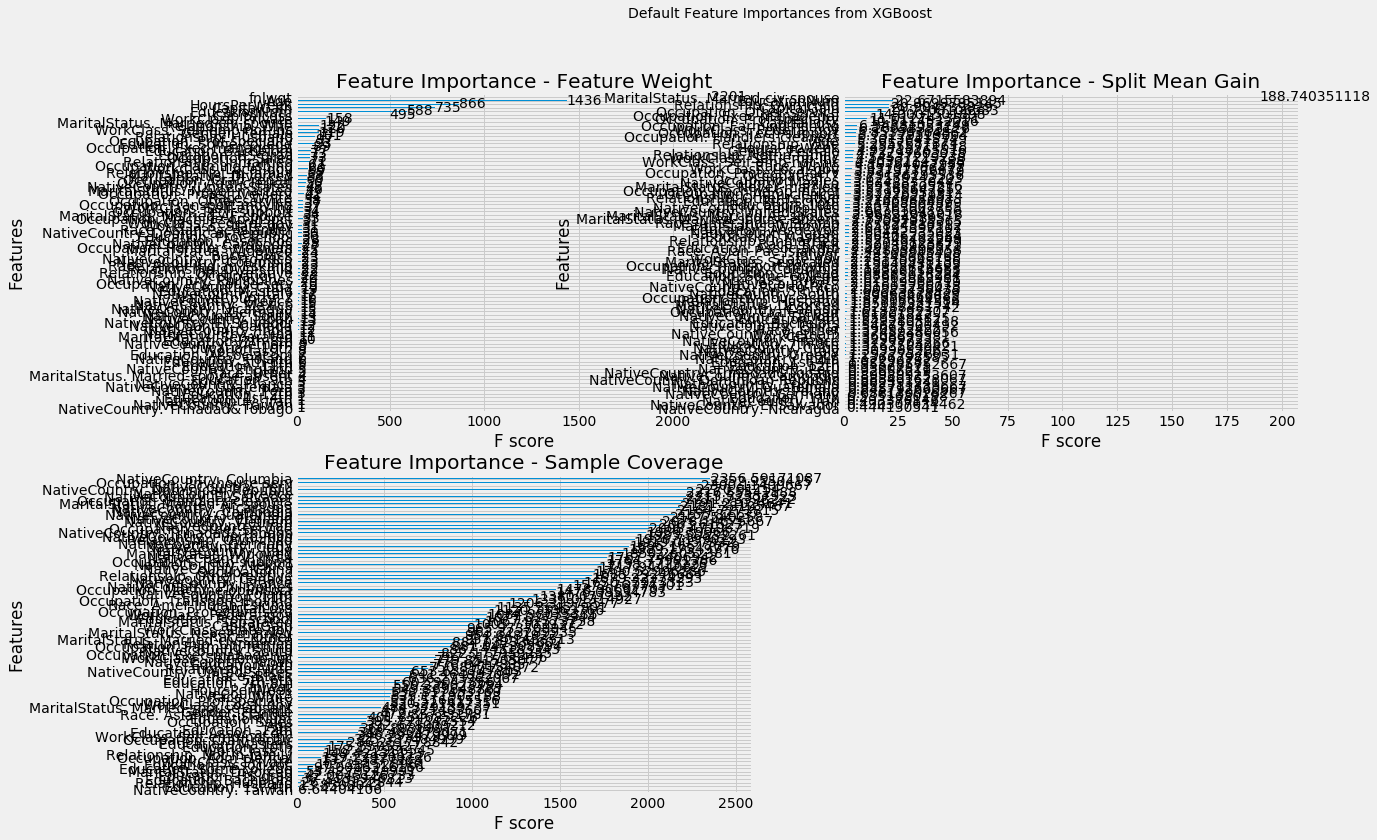

In [12]:
#¿qué nos proporciona directamente el algoritmo?
#Vamos a analizar los cálculos de importancia de caracteristicas que nos proporciona el algoritmo XGBoost, que nos posibilita ver la importancia de características basado en:
#Peso de la característica. el Número de veces que aparece la característica en un árbol a través del ensamblado de árboles
#Ganancia (Gain). Basado en la ganancia media de splits que usa la característica
#Covertura (Coverage). Número de muestras afectadas que utiliza la característica

#Veremos como en este caso, los resultados no son concluyentes, por lo que se hace necesario un framework que nos permita obtener la información correcta
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

In [14]:
import model_evaluation_utils as meu #es necesario tener el módulo model_evaluation_utils.py

#class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, 
                                      predicted_labels=predictions, 
                                      classes=feature_names)

Model Performance metrics:
------------------------------
('Accuracy:', 0.8716)
('Precision:', 0.8678)
('Recall:', 0.8716)
('F1 Score:', 0.869)

Model Classification report:
------------------------------
                                           precision    recall  f1-score   support

                                      Age       0.00      0.00      0.00         0
                                   fnlwgt       0.00      0.00      0.00         0
                             EducationNum       0.00      0.00      0.00         0
                              CapitalGain       0.00      0.00      0.00         0
                              CapitalLoss       0.00      0.00      0.00         0
                             HoursPerWeek       0.00      0.00      0.00         0
                             WorkClass. ?       0.00      0.00      0.00         0
                   WorkClass. Federal-gov       0.00      0.00      0.00         0
                     WorkClass. Local-gov      

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classific

ValueError: ignored

In [0]:
#Entrenando otro modelo

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#Blackbox system can include preprocessing, not just a classifier!
pca = PCA()
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

blackbox_model = Pipeline([('pca', pca), ('rf', rf)])
blackbox_model.fit(X_train, y_train)